In [4]:
import numpy as np
import tensorflow as tf


In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
X, y = mnist['data'], mnist['target']
print(X.shape)  # X being the images
print(y.shape)  # y being the labels(we will change this later to a int)

(70000, 784)
(70000,)


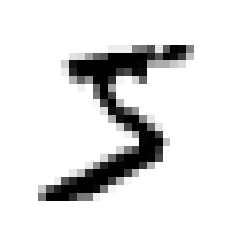

In [7]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[0] # This will show us the label of [0]

'5'

In [9]:
y = y.astype(np.uint8)

CREATE A TEST SET


In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits)

TRAINING A BINARY CLASSIFIER

We'll now simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [11]:
y_train_5 = (y_train == 5)  # True for all 5's, False for all other digits 
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we can use it to detect images of the number 5 

In [13]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). It guessed right in this particular case. Now, let’s evaluate this model’s performance.

PERFORMANCE MEASURES 


In [14]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Over 93% accuracy(ratio of correct predictions) on all cross-validation folds(cv=3), however lets try with a very dumb classifier that just classifies every single image in the "not-5" class

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy on this too, this is because only abut 10% of the images are 5's (in the code above we are predicting "not-5"), so if you guess than an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

CONFUSION MATRIX - A better way to evaluate the performance of a classifier


In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now lets get the confusion matrix using the confusion_matrix() function. We pass it the target class(y_train_5) and the predicted classes (y_train_pred)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])


Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left(53892) to bottom right(3530) like in the code below):

In [19]:
y_train_perfect_predictions = y_train_5   # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

PRECISION AND RECALL 

To compute classifier metrics Scikit-learn can provide serveral functions, including precision and recall

In [20]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # == 3530 / (3530+687)

print(recall_score(y_train_5, y_train_pred))   # == 3530/ (3530+1891)

0.8370879772350012
0.6511713705958311


The results above show that when our 5-detector claims an image representing a 5, it is correct 83.7% of the time, more over, it only detects 65.1% of the 5s 

It is often convenient to combine the precision and recall into a single metric called the F1 score

To compute the F1 score, we just call the f1_score() function

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

To decide which threshold to use, we will first need to get the scores of al instances in the training set using the cross_val_predict() fucntion again, but this time specifying that you want it to return decisin stores instead of predictions 

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Now with these scores we can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, we can plot precision and recall as functions of the threshold value using Matplotlib

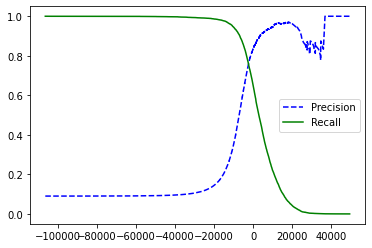

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend()
[...] # highlight the threshold, add the legend, axis label and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()

Now we'll plot precision directly against recall

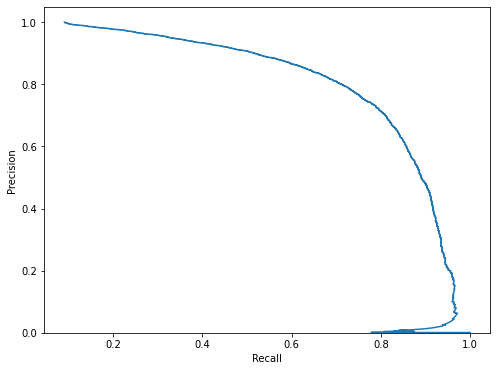

In [28]:
def plot_precision_recall_curve(precisions, recalls):
  plt.figure(figsize=(8, 6))
  plt.plot(precisions, recalls) 
  plt.ylim([0, max(plt.ylim())])
  plt.xlabel('Recall')
  _ = plt.ylabel('Precision')                  
plot_precision_recall_curve(precisions, recalls)
plt.show()

We will decide to aim at for 90% precision, we need to then find the  lowest threshold that gives you at least 90% precision, using mp.argmax() to give us the first index of the maximum value, which in this case mean the first True value.

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

To make predictions (only on the training set for now), instead of calling the classifiers predict() method, we can use the code below 

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Lets now check these predictions precision and recall

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

We have a 90% classifier, however a high-precision classifier is not very useful if its recall is too low (47.9% in this case) 

THE ROC CURVE 

To plot the ROC curve, we need to compute the TPR(true positive rate) and FPR(false postive rate) for various threshold values, using the roc_curve() function

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

The we can plot the FPR against the TPR(using Matplotlib)

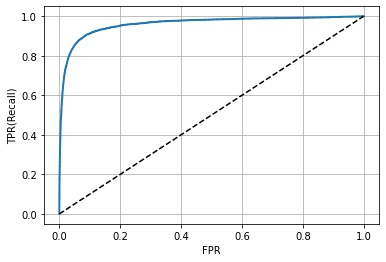

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('FPR')
  plt.ylabel('TPR(Recall)')
  plt.grid(True)
  ...
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (best place is toward the top-left corner).


One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. 

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

To plot the ROC curve we need scores, not probablities, the solution is to use the postive class's probability as the score 

In [37]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

Now we are ready to plot the ROC curve

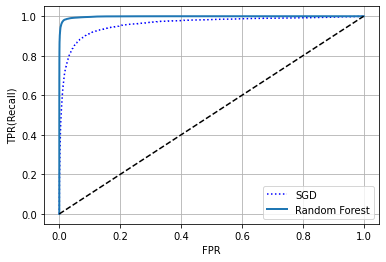

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As we can see the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better(code below)


In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

When measuring the precision and recall scores, we would find 99.0% precision and 86.6% recall

MULTICLASS CLASSIFICATION

Now lets try to detect more than just 5's - using multiclass classification 

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier:

In [40]:
sgd_clf.fit(X_train, y_train)  #y_train, NOT y_train_5 as we're using the other numbers too 
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction (a incorrect one in this case, going by the book). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that this is indeed the case, we will call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [41]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

The highest score will indeed be the one corresponding to class 3

In [42]:
np.argmax(some_digit_scores)

3

In [43]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
sgd_clf.classes_[3]

3

If we want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a SGDClassifier:

In [45]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
len(ovo_clf.estimators_)

45

In [47]:
some_digit_scores = ovo_clf.decision_function([some_digit])
some_digit_scores

array([[2.66666696, 3.66666714, 5.33333258, 8.33333319, 0.6666669 ,
        9.33333315, 0.66666684, 2.66666841, 5.33333214, 6.33333275]])

In [48]:
np.argmax(some_digit_scores)

5

In [49]:
ovo_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
ovo_clf.classes_[5]

5

This seems as though the OvO classifier based on the SGD classifier works better than OvA

Lets try with training a RandomForestClassifier

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [52]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

You can see that the classifier is fairly confident about its prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5. It also thinks that the image could instead be a 2, a 3 or a 9, respectively with 1%, 8% and 1% probability.

Now lets evaluate these classifiers, as usual we want to use cross-validation, lets evaluate the SGDClassifier's accuracy using the cross_val_score() function

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs increases accuracy above 89% (code below)

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

ERROR ANALYSIS 


In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx 

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

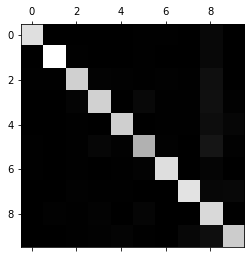

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums 

Now lets fill the diagonal with zeros to keep only the errors, and lets plot the result

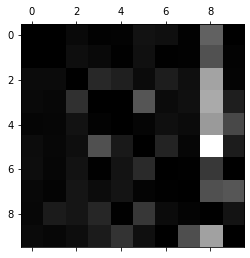

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analysing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time consuming. For example, lets plot examples of 3's and 5's (the plot_digit() function just uses Matplotlib's imshow() function)

In [59]:
def plot_digits(instances, images_per_row=10, **options):       #this code cell was from https://github.com/ageron/handson-ml/issues/257 for defining
    size = 28                                                   #plot_digits 
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

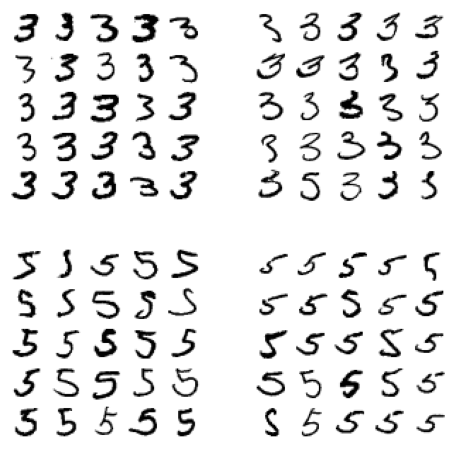

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) 
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) 
plt.show()

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 on the 1st row and 2nd column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did.3 The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.


MULTILABEL CLASSIFICATION

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #indicates whether or not the digit is large (7, 8, or 9)
y_train_odd = (y_train % 2 == 1)   # indicates whether or not it is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, but not all classifiers do) and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

The digit 5 is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code below computes the average F1 score across all labels

In [65]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, which may not be the case. In paticular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.